In [ ]:
import kagglehub

# gdp
path = kagglehub.dataset_download("krityodp/gdp-data-in-thailand")

print("Path to dataset files:", path)



Path to dataset files: /home/koala/.cache/kagglehub/datasets/krityodp/gdp-data-in-thailand/versions/1


'/home/koala/.cache/kagglehub/datasets/krityodp/gdp-data-in-thailand/versions/1'

In [ ]:
# carbon
path = kagglehub.dataset_download("thaweewatboy/thailand-carbon-emission-statistics")

print("Path to dataset files:", path)

In [12]:
import sdv

In [13]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------
# 1. Load and preprocess
# -----------------------
df = pd.read_csv("testDataset.csv").drop(columns=["Unnamed: 0"])
for col in ["Total power generation (GWh)", "Total electricity consumption (GWh)"]:
    df[col] = df[col].str.replace(",", "").astype(float)

# Add synthetic 'Day' column
df_expanded = pd.concat([df.assign(Day=day) for day in range(1, 366)], ignore_index=True)

# Normalize numeric columns
features = df_expanded.select_dtypes(include='number').columns.tolist()
scaler = StandardScaler()
data = scaler.fit_transform(df_expanded[features])
data_tensor = torch.tensor(data, dtype=torch.float)

# -----------------------
# 2. Define GAN Models
# -----------------------

latent_dim = 100
data_dim = data_tensor.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, data_dim)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()

# -----------------------
# 3. Training loop
# -----------------------
criterion = nn.BCELoss()
lr = 0.0002
batch_size = 128
epochs = 1000

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)

real_label = 1
fake_label = 0

for epoch in range(epochs):
    idx = np.random.randint(0, data_tensor.shape[0], batch_size)
    real_data = data_tensor[idx]

    # Train Discriminator
    optimizer_D.zero_grad()
    real_output = D(real_data)
    real_loss = criterion(real_output, torch.ones(batch_size, 1))
    
    z = torch.randn(batch_size, latent_dim)
    fake_data = G(z)
    fake_output = D(fake_data.detach())
    fake_loss = criterion(fake_output, torch.zeros(batch_size, 1))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    gen_output = D(fake_data)
    g_loss = criterion(gen_output, torch.ones(batch_size, 1))
    g_loss.backward()
    optimizer_G.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D_loss={d_loss.item():.4f}, G_loss={g_loss.item():.4f}")

# -----------------------
# 4. Generate new synthetic data
# -----------------------
with torch.no_grad():
    z = torch.randn(365 * 30, latent_dim)
    synthetic = G(z).numpy()
    synthetic_inverse = scaler.inverse_transform(synthetic)
    synthetic_df = pd.DataFrame(synthetic_inverse, columns=features)

# Optional: Save
synthetic_df.to_csv("custom_tabular_gan_synthetic.csv", index=False)


Epoch 0: D_loss=1.3532, G_loss=0.6680
Epoch 100: D_loss=1.1138, G_loss=0.9320
Epoch 200: D_loss=0.5882, G_loss=1.2706
Epoch 300: D_loss=0.3722, G_loss=2.5305
Epoch 400: D_loss=0.4479, G_loss=2.7153
Epoch 500: D_loss=0.6481, G_loss=1.4335
Epoch 600: D_loss=1.2977, G_loss=1.1163
Epoch 700: D_loss=0.7611, G_loss=1.5290
Epoch 800: D_loss=0.5986, G_loss=1.5197
Epoch 900: D_loss=0.8305, G_loss=1.3955


Data shape: (22, 11)
Using device: cpu
Epoch 50/1000, D Loss: 1.2721, G Loss: 0.8089
Epoch 100/1000, D Loss: 1.4302, G Loss: 0.7768
Epoch 150/1000, D Loss: 1.3836, G Loss: 0.8254
Epoch 200/1000, D Loss: 1.5586, G Loss: 0.6942
Epoch 250/1000, D Loss: 1.1900, G Loss: 0.7970
Epoch 300/1000, D Loss: 1.1313, G Loss: 0.7734
Epoch 350/1000, D Loss: 1.3067, G Loss: 0.6442
Epoch 400/1000, D Loss: 0.9659, G Loss: 0.7023
Epoch 450/1000, D Loss: 1.4341, G Loss: 0.7435
Epoch 500/1000, D Loss: 1.3125, G Loss: 0.6387
Epoch 550/1000, D Loss: 1.2117, G Loss: 1.2507
Epoch 600/1000, D Loss: 1.1734, G Loss: 0.5425
Epoch 650/1000, D Loss: 1.2318, G Loss: 0.6920
Epoch 700/1000, D Loss: 1.1518, G Loss: 0.9251
Epoch 750/1000, D Loss: 0.9785, G Loss: 0.8791
Epoch 800/1000, D Loss: 0.9755, G Loss: 0.8352
Epoch 850/1000, D Loss: 1.2816, G Loss: 0.7351
Epoch 900/1000, D Loss: 0.9753, G Loss: 0.8418
Epoch 950/1000, D Loss: 1.1173, G Loss: 0.7075
Epoch 1000/1000, D Loss: 0.9031, G Loss: 1.0073


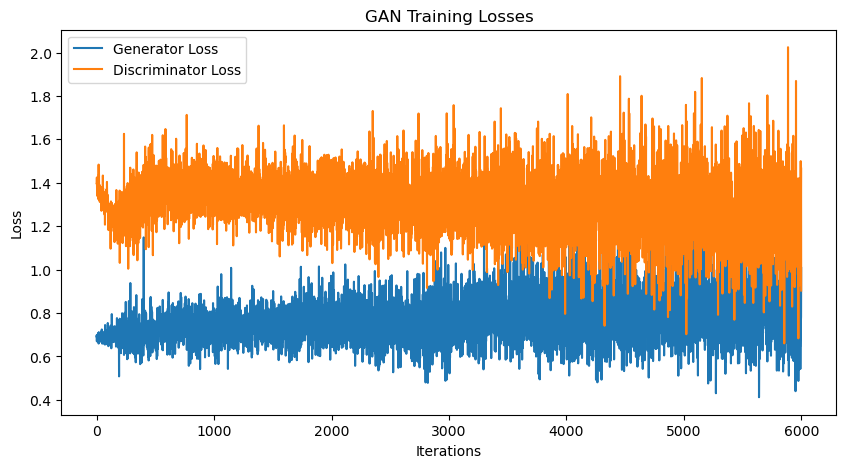


Original Data Sample:
      Unnamed: 0  Carbon Emissions(MtCO2)  UMD_Tree cover loss (ha)  \
Year                                                                  
2002           0                 184.6655              60882.189737   
2003           1                 191.0877              58447.942201   
2004           2                 207.3307              91835.294338   
2005           3                 214.3251              84287.060043   
2006           4                 215.8247              99820.579633   

      GFW_Gross emissions co2 (Mg)  Natural Gas (MtCO2)  Hydro (MtCO2)  \
Year                                                                     
2002                  3.119673e+07                45.14           0.18   
2003                  2.984648e+07                49.02           0.17   
2004                  4.718033e+07                51.65           0.14   
2005                  4.508730e+07                54.04           0.13   
2006                  5.214129e+07 

KeyError: 'Total power generation (GWh)'

<Figure size 1200x600 with 0 Axes>

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the data
def load_and_preprocess_data(file_path='testDataset.csv'):
    df = pd.read_csv(file_path)
    
    # Extract year as index and convert other columns to float
    df['Year'] = df.iloc[:, 1].astype(int)
    df = df.set_index('Year')
    
    # Select numeric columns and convert to float
    numeric_columns = df.select_dtypes(include=['number']).columns
    float_columns = [col for col in numeric_columns if col != 'Year']
    df_numeric = df[float_columns].copy()
    
    # Remove commas and convert to float
    for col in df_numeric.columns:
        if df_numeric[col].dtype == 'object':
            df_numeric[col] = df_numeric[col].str.replace(',', '').astype(float)
            
    # Scale the data between -1 and 1 for GAN training
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(df_numeric.values)
    
    return df_numeric, scaled_data, scaler

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.hidden_dim = 128
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim),
            
            nn.Linear(self.hidden_dim, self.hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim * 2),
            
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim),
            
            nn.Linear(self.hidden_dim, output_dim),
            nn.Tanh()  # Output activation to match scaled data range (-1, 1)
        )
        
    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        
        self.hidden_dim = 128
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(self.hidden_dim // 2, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )
        
    def forward(self, x):
        return self.model(x)

# Time-aware conditioning for GAN
class TimeSeriesGAN:
    def __init__(self, data_dim, latent_dim, device='cpu'):
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.device = device
        
        # Initialize generator and discriminator
        self.generator = Generator(latent_dim, data_dim).to(device)
        self.discriminator = Discriminator(data_dim).to(device)
        
        # Setup optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # Loss function
        self.criterion = nn.BCELoss()
        
        # For tracking progress
        self.g_losses = []
        self.d_losses = []
    
    def train(self, dataloader, epochs=500):
        for epoch in range(epochs):
            for real_data in dataloader:
                real_data = real_data[0].to(self.device)
                batch_size = real_data.size(0)
                
                # Create labels for real and fake data
                real_labels = torch.ones(batch_size, 1).to(self.device)
                fake_labels = torch.zeros(batch_size, 1).to(self.device)
                
                # -----------------
                # Train Discriminator
                # -----------------
                self.d_optimizer.zero_grad()
                
                # Train with real data
                outputs_real = self.discriminator(real_data)
                d_loss_real = self.criterion(outputs_real, real_labels)
                
                # Train with fake data
                noise = torch.randn(batch_size, self.latent_dim).to(self.device)
                fake_data = self.generator(noise)
                outputs_fake = self.discriminator(fake_data.detach())
                d_loss_fake = self.criterion(outputs_fake, fake_labels)
                
                # Compute total discriminator loss
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                self.d_optimizer.step()
                
                # -----------------
                # Train Generator
                # -----------------
                self.g_optimizer.zero_grad()
                
                # Generate fake data again
                noise = torch.randn(batch_size, self.latent_dim).to(self.device)
                fake_data = self.generator(noise)
                outputs = self.discriminator(fake_data)
                
                # Generator aims to fool the discriminator
                g_loss = self.criterion(outputs, real_labels)
                g_loss.backward()
                self.g_optimizer.step()
                
                # Store losses
                self.g_losses.append(g_loss.item())
                self.d_losses.append(d_loss.item())
            
            # Print progress
            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    def generate_samples(self, num_samples, scaler):
        with torch.no_grad():
            # Generate random noise
            noise = torch.randn(num_samples, self.latent_dim).to(self.device)
            
            # Generate fake data
            fake_data = self.generator(noise).cpu().numpy()
            
            # Inverse transform to get original scale
            generated_data = scaler.inverse_transform(fake_data)
            
            return generated_data
    
    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GAN Training Losses')
        plt.show()

# Main function to run the GAN
def run_timeseries_gan():
    # Load and preprocess data
    df, scaled_data, scaler = load_and_preprocess_data()
    print(f"Data shape: {scaled_data.shape}")
    
    # Convert to PyTorch tensors
    tensor_data = torch.FloatTensor(scaled_data)
    dataset = TensorDataset(tensor_data)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # Initialize and train GAN
    data_dim = scaled_data.shape[1]
    latent_dim = 50  # Dimension of random noise input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    
    gan = TimeSeriesGAN(data_dim, latent_dim, device)
    gan.train(dataloader, epochs=1000)
    
    # Plot training losses
    gan.plot_losses()
    
    # Generate new samples
    num_new_samples = 10  # Generate 10 new "years" of data
    generated_data = gan.generate_samples(num_new_samples, scaler)
    
    # Create a DataFrame with the generated data
    generated_df = pd.DataFrame(generated_data, columns=df.columns)
    
    # Assign years to the generated data (continuing from the original dataset)
    last_year = df.index.max()
    new_years = range(last_year + 1, last_year + num_new_samples + 1)
    generated_df.index = new_years
    generated_df.index.name = 'Year'
    
    print("\nOriginal Data Sample:")
    print(df.head())
    
    print("\nGenerated Data:")
    print(generated_df)
    
    # Plot original vs generated for a sample column
    sample_column = 'Total power generation (GWh)'
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    plt.plot(df.index, df[sample_column], 'b-', label='Original Data')
    
    # Plot generated data
    plt.plot(generated_df.index, generated_df[sample_column], 'r--', label='Generated Data')
    
    plt.xlabel('Year')
    plt.ylabel(sample_column)
    plt.title(f'Original vs Generated {sample_column}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df, generated_df

if __name__ == "__main__":
    original_data, generated_data = run_timeseries_gan()

Yearly data loaded:
      Unnamed: 0  Carbon Emissions(MtCO2)  UMD_Tree cover loss (ha)  \
Year                                                                  
2002           0                 184.6655              60882.189737   
2003           1                 191.0877              58447.942201   
2004           2                 207.3307              91835.294338   
2005           3                 214.3251              84287.060043   
2006           4                 215.8247              99820.579633   

      GFW_Gross emissions co2 (Mg)  Natural Gas (MtCO2)  Hydro (MtCO2)  \
Year                                                                     
2002                  3.119673e+07                45.14           0.18   
2003                  2.984648e+07                49.02           0.17   
2004                  4.718033e+07                51.65           0.14   
2005                  4.508730e+07                54.04           0.13   
2006                  5.214129e+07    

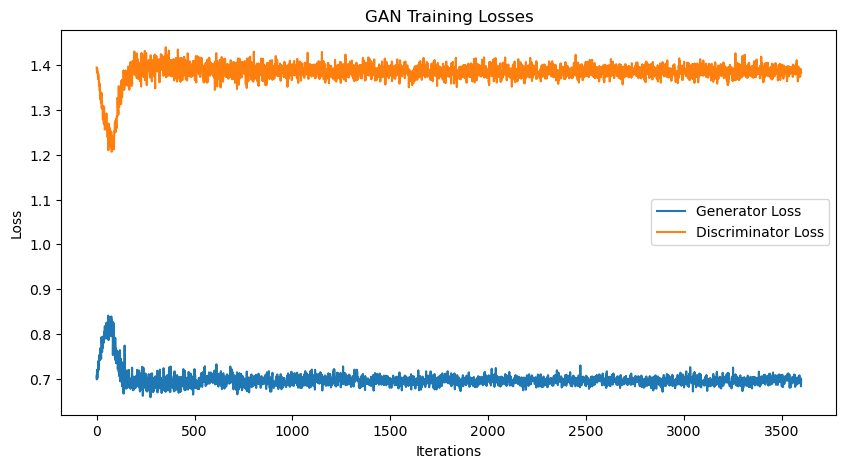

Generating daily data for each year...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...
Processing year 2021...
Processing year 2022...
Processing year 2023...
Generated daily data shape: (8035, 11)
Number of dates: 8035
Daily upsampled data saved to daily_upsampled_data.csv


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime
import calendar
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the yearly data
def load_yearly_data(file_path='testDataset.csv'):
    df = pd.read_csv(file_path)
    
    # Extract year and use it as index
    df['Year'] = df.iloc[:, 1].astype(int)
    df = df.set_index('Year')
    
    # Select numeric columns and convert to float
    numeric_columns = df.select_dtypes(include=['number']).columns
    float_columns = [col for col in numeric_columns if col != 'Year']
    df_numeric = df[float_columns].copy()
    
    # Remove commas and convert to float
    for col in df_numeric.columns:
        if df_numeric[col].dtype == 'object':
            df_numeric[col] = df_numeric[col].str.replace(',', '').astype(float)
    
    return df_numeric

# Create temporal features for conditioning the GAN
def create_temporal_features(days_in_year=365):
    # Create normalized features for day of year (0-1 scale)
    day_of_year = np.arange(days_in_year) / days_in_year
    
    # Create sine and cosine transformations for cyclical patterns
    sine_day = np.sin(2 * np.pi * day_of_year)
    cosine_day = np.cos(2 * np.pi * day_of_year)
    
    # Create quarter/season indicator (4 seasons)
    quarter = np.zeros((days_in_year, 4))
    for i in range(days_in_year):
        if i < days_in_year/4:
            quarter[i, 0] = 1
        elif i < days_in_year/2:
            quarter[i, 1] = 1
        elif i < 3*days_in_year/4:
            quarter[i, 2] = 1
        else:
            quarter[i, 3] = 1
    
    # Combine features
    temporal_features = np.column_stack((day_of_year, sine_day, cosine_day, quarter))
    
    return temporal_features

# Define the Generator for daily patterns
class Generator(nn.Module):
    def __init__(self, noise_dim, temporal_features_dim, output_dim):
        super(Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.temporal_features_dim = temporal_features_dim
        self.output_dim = output_dim
        self.hidden_dim = 128
        
        # Process noise
        self.noise_processor = nn.Sequential(
            nn.Linear(noise_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim)
        )
        
        # Process temporal features
        self.temporal_processor = nn.Sequential(
            nn.Linear(temporal_features_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim)
        )
        
        # Combined processor
        self.combined_processor = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim * 2),
            
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(self.hidden_dim),
            
            nn.Linear(self.hidden_dim, output_dim),
            nn.Tanh()  # Output activation for normalized values
        )
        
    def forward(self, noise, temporal_features):
        noise_processed = self.noise_processor(noise)
        temporal_processed = self.temporal_processor(temporal_features)
        
        combined = torch.cat((noise_processed, temporal_processed), dim=1)
        return self.combined_processor(combined)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, data_dim, temporal_features_dim):
        super(Discriminator, self).__init__()
        
        self.data_dim = data_dim
        self.temporal_features_dim = temporal_features_dim
        self.hidden_dim = 128
        
        # Process data
        self.data_processor = nn.Sequential(
            nn.Linear(data_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Process temporal features
        self.temporal_processor = nn.Sequential(
            nn.Linear(temporal_features_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Combined processor
        self.combined_processor = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(self.hidden_dim, 1),
            nn.Sigmoid()  # Output probability
        )
        
    def forward(self, data, temporal_features):
        data_processed = self.data_processor(data)
        temporal_processed = self.temporal_processor(temporal_features)
        
        combined = torch.cat((data_processed, temporal_processed), dim=1)
        return self.combined_processor(combined)

# GAN for upsampling yearly data to daily
class DailyUpsamplingGAN:
    def __init__(self, data_dim, noise_dim, temporal_features_dim, device='cpu'):
        self.data_dim = data_dim
        self.noise_dim = noise_dim
        self.temporal_features_dim = temporal_features_dim
        self.device = device
        
        # Initialize networks
        self.generator = Generator(noise_dim, temporal_features_dim, data_dim).to(device)
        self.discriminator = Discriminator(data_dim, temporal_features_dim).to(device)
        
        # Setup optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # Loss function
        self.criterion = nn.BCELoss()
        
        # For tracking progress
        self.g_losses = []
        self.d_losses = []
    
    def train(self, dataloader, epochs=300):
        for epoch in range(epochs):
            for batch in dataloader:
                temporal_features, noise = batch
                temporal_features = temporal_features.to(self.device)
                noise = noise.to(self.device)
                batch_size = temporal_features.size(0)
                
                # Create labels
                real_labels = torch.ones(batch_size, 1).to(self.device)
                fake_labels = torch.zeros(batch_size, 1).to(self.device)
                
                # -----------------
                # Train Discriminator with synthetic data
                # -----------------
                self.d_optimizer.zero_grad()
                
                # Create random daily patterns (acting as "real" data)
                # This is like a prior of what daily patterns might look like
                real_daily_patterns = torch.randn(batch_size, self.data_dim).to(self.device) * 0.1 + torch.sin(temporal_features[:, 1:2] * 3).repeat(1, self.data_dim) * 0.3
                
                # Discriminator on "real" data
                d_real_output = self.discriminator(real_daily_patterns, temporal_features)
                d_real_loss = self.criterion(d_real_output, real_labels)
                
                # Generate fake data
                fake_daily_patterns = self.generator(noise, temporal_features)
                
                # Discriminator on fake data
                d_fake_output = self.discriminator(fake_daily_patterns.detach(), temporal_features)
                d_fake_loss = self.criterion(d_fake_output, fake_labels)
                
                # Combined discriminator loss
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                self.d_optimizer.step()
                
                # -----------------
                # Train Generator
                # -----------------
                self.g_optimizer.zero_grad()
                
                # Generate fake data again
                fake_daily_patterns = self.generator(noise, temporal_features)
                
                # Discriminator on fake data
                d_output = self.discriminator(fake_daily_patterns, temporal_features)
                
                # Generator loss - try to fool discriminator
                g_loss = self.criterion(d_output, real_labels)
                
                # Add seasonal pattern loss - encourage realistic seasonal patterns
                seasonal_pattern_loss = torch.mean(torch.abs(
                    fake_daily_patterns.mean(dim=0) - 
                    torch.sin(temporal_features[:, 1:2].mean(dim=0)).repeat(self.data_dim) * 0.2
                ))
                
                # Add daily variation loss - ensure there's some variation between days
                daily_var_loss = -torch.mean(torch.std(fake_daily_patterns, dim=0))
                
                # Combined generator loss
                combined_g_loss = g_loss + seasonal_pattern_loss * 0.5 + daily_var_loss * 0.3
                combined_g_loss.backward()
                self.g_optimizer.step()
                
                # Store losses
                self.g_losses.append(g_loss.item())
                self.d_losses.append(d_loss.item())
            
            # Print progress
            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    def generate_daily_data_for_year(self, year_data, temporal_features):
        """Generate daily data for a single year"""
        # Convert temporal features to tensor
        temporal_features_tensor = torch.FloatTensor(temporal_features).to(self.device)
        batch_size = temporal_features_tensor.size(0)
        
        with torch.no_grad():
            # Generate consistent noise
            noise = torch.randn(batch_size, self.noise_dim).to(self.device)
            
            # Generate daily patterns
            daily_patterns = self.generator(noise, temporal_features_tensor).cpu().numpy()
            
            # Normalize to ensure the values aggregate to yearly totals
            normalized_daily_data = np.zeros_like(daily_patterns)
            
            # For each column in the data
            for col in range(daily_patterns.shape[1]):
                # Shift to all positive if needed
                min_val = daily_patterns[:, col].min()
                if min_val < 0:
                    daily_patterns[:, col] -= min_val
                
                # Sum of generated patterns for this column
                pattern_sum = daily_patterns[:, col].sum()
                if pattern_sum > 0:  # Avoid division by zero
                    # Scale to match yearly total
                    yearly_total = year_data.iloc[col]
                    normalized_daily_data[:, col] = daily_patterns[:, col] * (yearly_total / pattern_sum)
            
            return normalized_daily_data
    
    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GAN Training Losses')
        plt.show()

# Main function to upsample yearly data to daily and save results
def upsample_yearly_to_daily_and_save(output_path='daily_upsampled_data.csv'):
    # Load yearly data
    yearly_data = load_yearly_data()
    print("Yearly data loaded:")
    print(yearly_data.head())
    
    # Get year range
    start_year = yearly_data.index.min()
    end_year = yearly_data.index.max()
    
    # Create temporal features for a standard year
    std_days_in_year = 365
    temporal_features = create_temporal_features(std_days_in_year)
    temporal_features_tensor = torch.FloatTensor(temporal_features)
    
    # Create dummy noise for training
    noise_dim = 100
    noise = torch.randn(std_days_in_year, noise_dim)
    
    # Create dataloader for training
    dataset = TensorDataset(temporal_features_tensor, noise)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Initialize and train GAN
    data_dim = yearly_data.shape[1]
    temporal_features_dim = temporal_features.shape[1]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    print(f"Training GAN to learn daily patterns...")
    
    gan = DailyUpsamplingGAN(data_dim, noise_dim, temporal_features_dim, device)
    gan.train(dataloader, epochs=300)
    
    # Plot training losses
    gan.plot_losses()
    
    # Generate daily data for each year and combine
    print("Generating daily data for each year...")
    all_daily_data = []
    all_dates = []
    
    for year in range(start_year, end_year + 1):
        print(f"Processing year {year}...")
        # Get yearly data for this year
        year_data = yearly_data.loc[year]
        
        # Check if leap year and create appropriate temporal features
        is_leap_year = calendar.isleap(year)
        days_in_year = 366 if is_leap_year else 365
        
        if is_leap_year:
            # Create special temporal features for leap year
            temporal_features_leap = create_temporal_features(days_in_year)
            year_daily_data = gan.generate_daily_data_for_year(year_data, temporal_features_leap)
        else:
            # Use standard temporal features
            year_daily_data = gan.generate_daily_data_for_year(year_data, temporal_features)
        
        # Create dates for this year
        start_date = datetime.date(year, 1, 1)
        end_date = datetime.date(year, 12, 31)
        delta = datetime.timedelta(days=1)
        
        year_dates = []
        current_date = start_date
        while current_date <= end_date:
            year_dates.append(current_date)
            current_date += delta
        
        # Ensure data and dates match in length
        assert len(year_dates) == year_daily_data.shape[0], f"Mismatch for year {year}: {len(year_dates)} dates vs {year_daily_data.shape[0]} data points"
        
        # Store data and dates
        all_daily_data.append(year_daily_data)
        all_dates.extend(year_dates)
    
    # Combine all years' data
    combined_daily_data = np.vstack(all_daily_data)
    
    print(f"Generated daily data shape: {combined_daily_data.shape}")
    print(f"Number of dates: {len(all_dates)}")
    
    # Create dataframe
    daily_df = pd.DataFrame(
        combined_daily_data, 
        columns=yearly_data.columns,
        index=all_dates
    )

    # Convert index to DatetimeIndex
    daily_df.index = pd.to_datetime(daily_df.index)

    # Add Year, Month, Day columns
    daily_df['Year'] = daily_df.index.year
    daily_df['Month'] = daily_df.index.month
    daily_df['Day'] = daily_df.index.day

    
    # Add Year, Month, Day columns
    # daily_df['Year'] = daily_df.index.year
    # daily_df['Month'] = daily_df.index.month
    # daily_df['Day'] = daily_df.index.day
    
    # Reorder columns to have date columns first
    cols = ['Year', 'Month', 'Day'] + list(yearly_data.columns)
    daily_df = daily_df[cols]
    
    # Save to CSV
    daily_df.to_csv(output_path)
    print(f"Daily upsampled data saved to {output_path}")
    
    # Plot a sample of the daily data for a few columns
    # sample_cols = ['Total power generation (GWh)', 'Carbon Emissions(MtCO2)']
    # plt.figure(figsize=(15, 10))
    
    # for i, col in enumerate(sample_cols):
    #     plt.subplot(len(sample_cols), 1, i+1)
        
    #     # Plot daily values for first and last years
    #     first_year = start_year
    #     last_year = end_year
        
    #     first_year_data = daily_df[daily_df['Year'] == first_year][col]
    #     last_year_data = daily_df[daily_df['Year'] == last_year][col]
        
    #     plt.plot(first_year_data.values, label=f'{first_year}')
    #     plt.plot(last_year_data.values, label=f'{last_year}')
        
    #     plt.title(f'Daily {col}')
    #     plt.ylabel(col)
    #     plt.legend()
        
    # plt.tight_layout()
    # plt.savefig('daily_patterns_comparison.png')
    # plt.show()
    
    return daily_df

if __name__ == "__main__":
    daily_df = upsample_yearly_to_daily_and_save()